In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
from pathlib import Path

import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

from loanapprovalprediction.constants import (
    CATEGORICAL_VARIABLES,
    CONTINUOUS_VARIABLES,
    TARGET,
)

sns.set_theme()

DATA_DIR = Path(os.getcwd()).parent / "data"

In [4]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

## Preprocess data

In [5]:
scaler = StandardScaler()

def preprocess_data(data: pd.DataFrame, scaler: StandardScaler, fit:bool=False) -> pd.DataFrame:
    if fit:
        X_cont = scaler.fit_transform(data[CONTINUOUS_VARIABLES])
    else:
        X_cont = scaler.transform(data[CONTINUOUS_VARIABLES])

    return pd.concat([
        pd.DataFrame(X_cont, columns=CONTINUOUS_VARIABLES), 
        data[CATEGORICAL_VARIABLES].apply(pd.Categorical)], axis=1
    )

X_train = preprocess_data(train, scaler, fit=True)
X_test = preprocess_data(test, scaler)

In [6]:
from xgboost import XGBClassifier

clf = XGBClassifier(enable_categorical=True, device="cuda")
clf.fit(X_train, train[TARGET])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

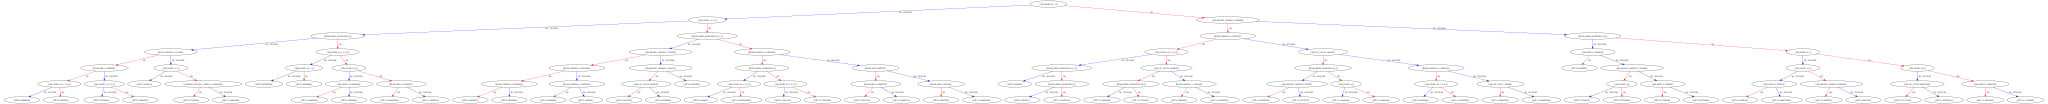

In [10]:
graph = xgb.to_graphviz(clf, num_trees=1)
graph

In [14]:
clf.score(X_train, train[TARGET])

0.9612584193025834

In [17]:
preds = clf.predict(X_test)

In [20]:
test.assign(loan_status = preds)[["id", TARGET]].to_csv(DATA_DIR / "submission.csv", index=False)

In [22]:
!kaggle competitions submit -c playground-series-s4e10 -f ../data/submission.csv -m "Initial submission"

100%|█████████████████████████████████████████| 305k/305k [00:00<00:00, 659kB/s]
Successfully submitted to Loan Approval Prediction

In [ ]:
# Score on initial submission: 0.86906